### NeuroDOT_py Preprocessing Script
 This script includes details on the Preprocessing pipeline. <br>
 A file of sample data is already designated below, but you can use the "loadmat_py function to load your own optical data in 'mat' file format. <br>
 In order to load the sample file, change the path below in the "sys.path.insert" lines to the folder under which you have NeuroDOT_py installed.

In [8]:
# Install all required libraries for running NeuroDOT (only needs to be done on first use)
!pip install -r ./requirements.txt

In [2]:
# General imports
import sys
import math
import os
import shutil
import json


import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import scipy.interpolate
import numpy.matlib as mlb
import numpy.matlib as nm
import functools as ft

from math import trunc
from pickle import NONE
from numpy import float64, matrix
from numpy.lib.shape_base import expand_dims
from matplotlib.pyplot import colorbar, colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D

sys.path.insert(0,'./neuro_dot') 

from Visualizations import viz
from Spatial_Transforms import sx4m
from Temporal_Transforms import tx4m
from Light_Modeling import lmdl
from File_IO import io
from Analysis import anlys
from DynamicFilter import DynamicFilter
from Matlab_Equivalent_Functions import matlab

In [3]:
# To get started, edit this cell for folder paths; EDIT AT THE BEGINNING ONLY
saveImages = 'yes' # Options are yes/no to save output figures (must be lowercase 'yes' or 'no')
saveImagePath ="./Output" # Path to folder to save output, figures will be saved to subdirectory called 'Output_Images'
saveNoteBookPath = "./Output" # Path to folder to save output, Jupyter Notebook will be saved to subdirectory called 'Output_Notebook'

In [4]:
# To get started, edit this cell for folder paths; EDIT AT THE BEGINNING ONLY
saveImages = 'yes' # Options are yes/no to save output figures (must be lowercase 'yes' or 'no')
saveImagePath ="./outputfiles" # Path to folder to save output, figures will be saved to subdirectory called 'Output_Images'
saveNoteBookPath = "./outputfiles" # Path to folder to save output, Jupyter Notebook will be saved to subdirectory called 'Output_Notebook'

# RUN THIS CELL ONLY ONCE IF YOU CHOOSE TO RE RUN THE CELL ABOVE FIRST
if saveImages == 'yes':
    saveImagePath = saveImagePath + '/Output_Images/'
    if not os.path.exists(saveImagePath): 
        os.makedirs(saveImagePath)
    # The code below is only relevant for use with XNAT container
    saveNoteBookPath = saveNoteBookPath + '/Output_Notebook/'
    if not os.path.exists(saveNoteBookPath):
        os.makedirs(saveNoteBookPath)
else:
    print('SAVED IMAGES IS SET TO NO. NO IMAGES WILL BE SAVED.')

In [22]:
# TO MAKE CHANGES TO FIGURES, EDIT ONLY THIS CELL
# patient_data = "/input/subjectdata.mat"  # Path to data; an example data set has been provided here
patient_data = "./Data/NeuroDOT_Data_Sample_CCW1"
params_file = "./Data/params.txt"
a = ""
with open(params_file) as f:
    for line in f: 
        a = a + line.strip()
params = json.loads(a)
# If you want to change an individual or a few params, just follow syntax below (NOTE: make changes before 'print' statements to confirm dictionary updates): 
# params['bthresh'] = 0.075
print("Params being used: \n")
print(params)

Params being used: 

{'bthresh': 0.075, 'det': 1, 'highpass': 1, 'lowpass1': 1, 'ssr': 1, 'lowpass2': 1, 'DoGVTD': 1, 'resample': 1, 'omega_hp': 0.02, 'omega_lp1': 1, 'omega_lp2': 0.5, 'freqout': 1, 'rstol': 0.001, 'DQC_ONLY': 0, 'omega_resample': 1, 'dt': 36, 'tp': 16}


In [14]:
# Load your data file, or one of the provided data samples using the absolute path to the file (.mat format)
data = io.loadmat(patient_data)['data'] 
__info = io.loadmat(patient_data)['info'] 
flags = io.loadmat(patient_data)['flags']

In [15]:
# Set parameters for A and block length for quick processing examples
if 'CCW1' in patient_data or 'CCW2' in patient_data or 'CW1' in patient_data or 'OUT' in patient_data:
    params['dt']=36                     # Block length
    params['tp']=16                     # Example (block averaged) time point
if 'IN1' in patient_data:
    params['dt']=36                     # Block length
    params['tp']=32                     # Example (block averaged) time point

if  'HW1'in patient_data or'HW2' in patient_data or'RW1' in patient_data or'GV1'in patient_data or'HW3_Noisy' in patient_data:
    params['dt']=30                     # Block length
    params['tp']=16                     # Example (block averaged) time point

# Make sure params correspond to the data type
print('dt:', params['dt'])
print('tp:', params['tp'])

dt: 36
tp: 16


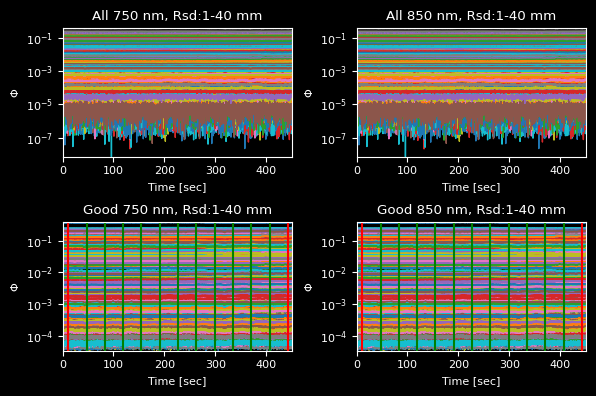

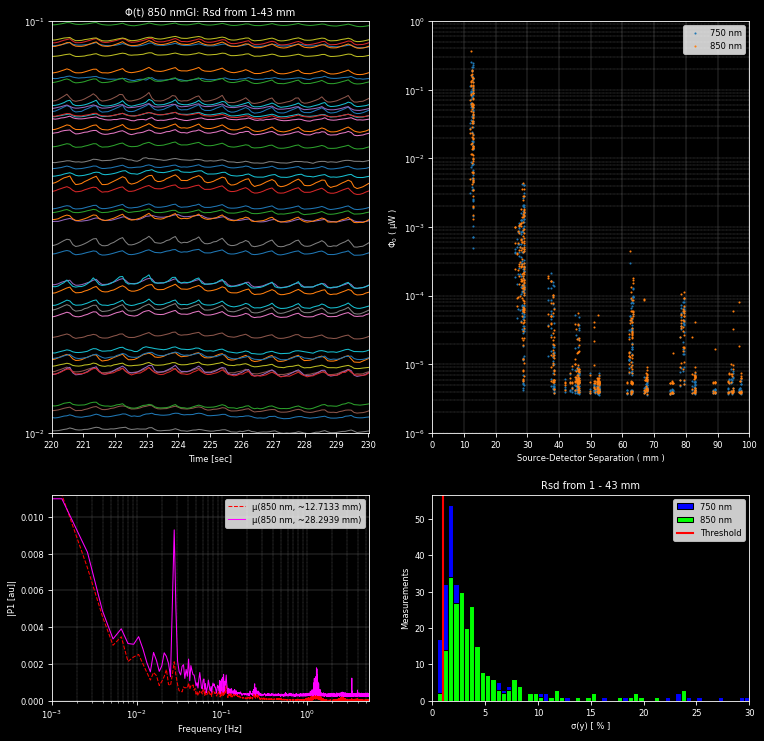

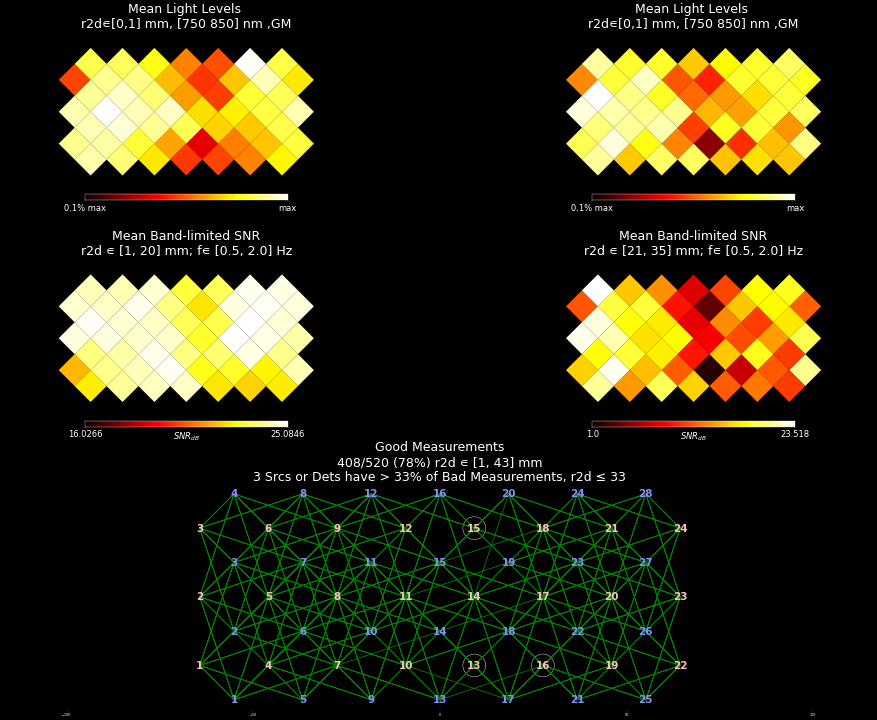

In [16]:
params_metricsII = params.copy()
params_cap = params.copy()

viz.Plot_RawData_Time_Traces_Overview(data,__info, params)   # Time traces
filename = saveImagePath +'Time_Traces_Overview.png'
if saveImages == 'yes':
    plt.savefig(filename,format = 'png')

viz.Plot_RawData_Metrics_II_DQC(data,__info, params_metricsII)         # Spectrum, falloff, and good signal metric
filename = saveImagePath +'RawData_Metrics_II.png'
if saveImages == 'yes':
    plt.savefig(filename,format = 'png')
    
__info_out = viz.Plot_RawData_Cap_DQC(data,__info, params_cap)   # Cap-relevant views
filename = saveImagePath +'RawData_Cap_DQC.png'
if saveImages == 'yes':
    plt.savefig(filename,format = 'png')

In [16]:
## Logmean Light Levels
lmdata = tx4m.logmean(data)[0]

./Output/Output_Images/fft_lml.png


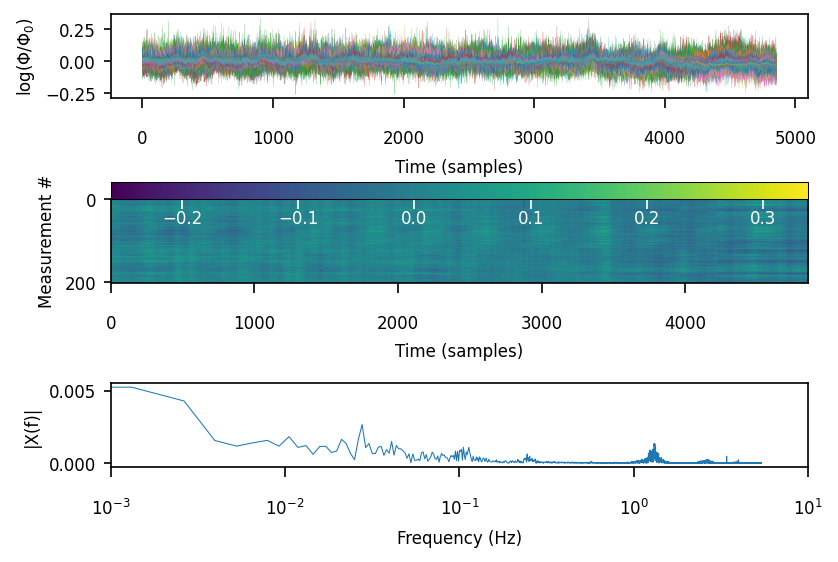

In [17]:
## Detect Noisy Channels
info = anlys.FindGoodMeas(lmdata, __info, 0.075)

# Example visualization
keep = np.logical_and(np.logical_and(np.where(info['pairs']['WL'] == 2,1,0), np.where(info['pairs']['r2d'] < 40,1,0)), info['MEAS']['GI']) # measurements to include

DynamicFilter(data,info, params,'fft_lml', saveImages,saveImagePath)

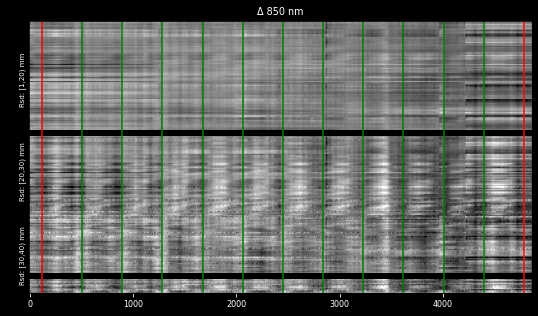

In [18]:
## Show nn1, nn2, nn3 (plots)
viz.nlrGrayPlots_220324(lmdata,info)
filename = saveImagePath +'nlrGrayPlots.png'
if saveImages == 'yes':
    plt.savefig(filename,format = 'png')

./Output/Output_Images/lml.png


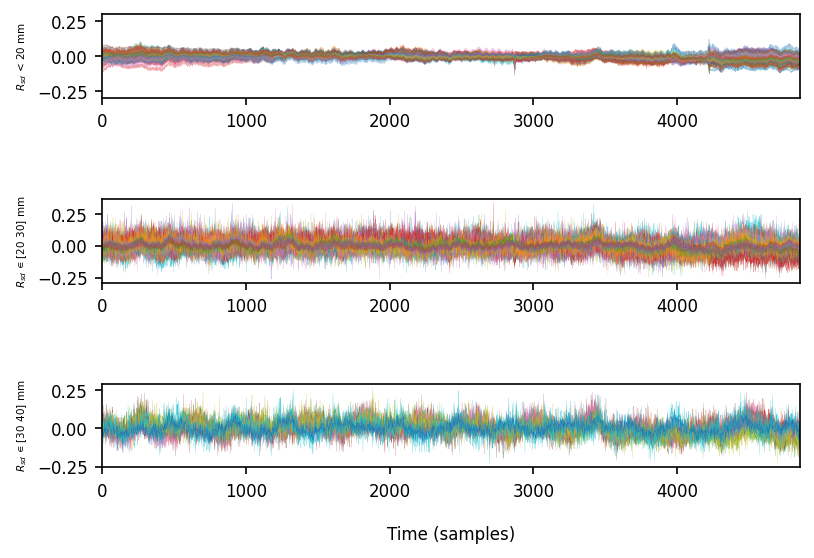

In [19]:
DynamicFilter(data,info, params,'lml',saveImages,saveImagePath)

./Output/Output_Images/fft_dt_hp.png


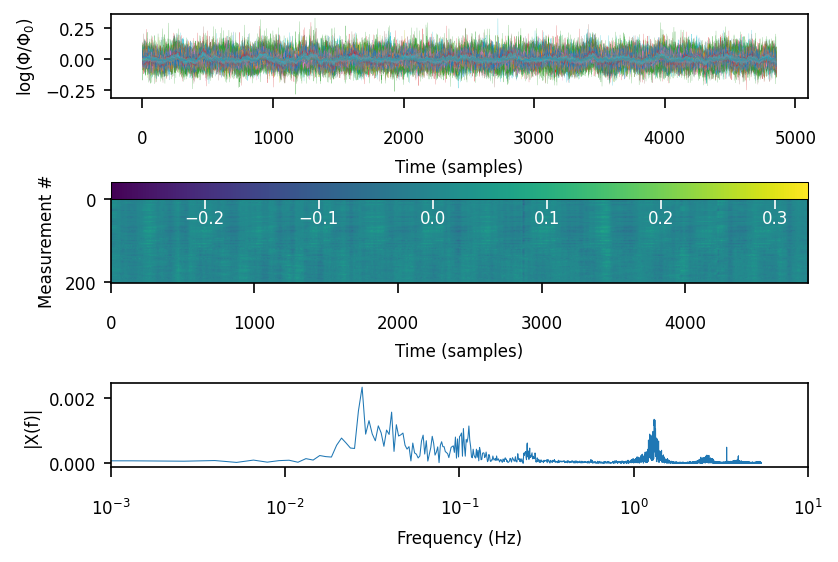

In [20]:
## Detrend and High-pass Filter the Data
DynamicFilter(data,info, params,'fft_dt_hp',saveImages,saveImagePath)

./Output/Output_Images/high_pass.png


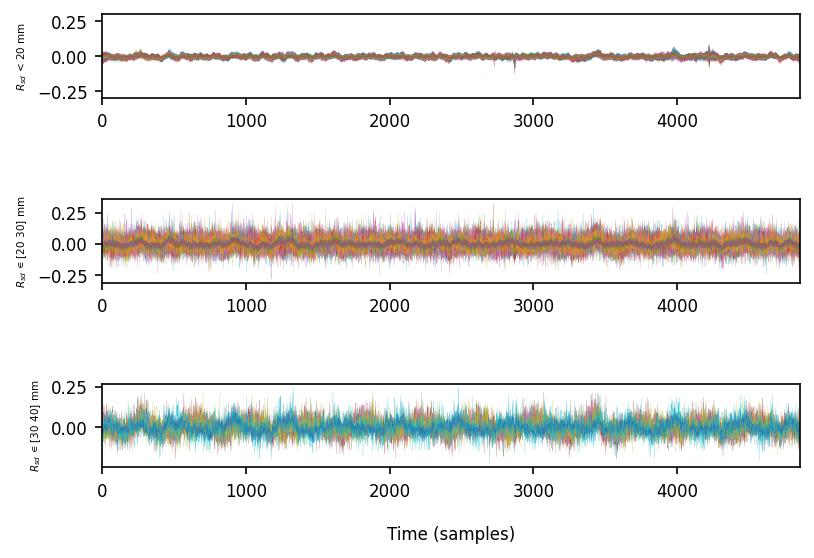

In [21]:
DynamicFilter(data,info, params,'high_pass',saveImages,saveImagePath)

./Output/Output_Images/low_pass_fft.png


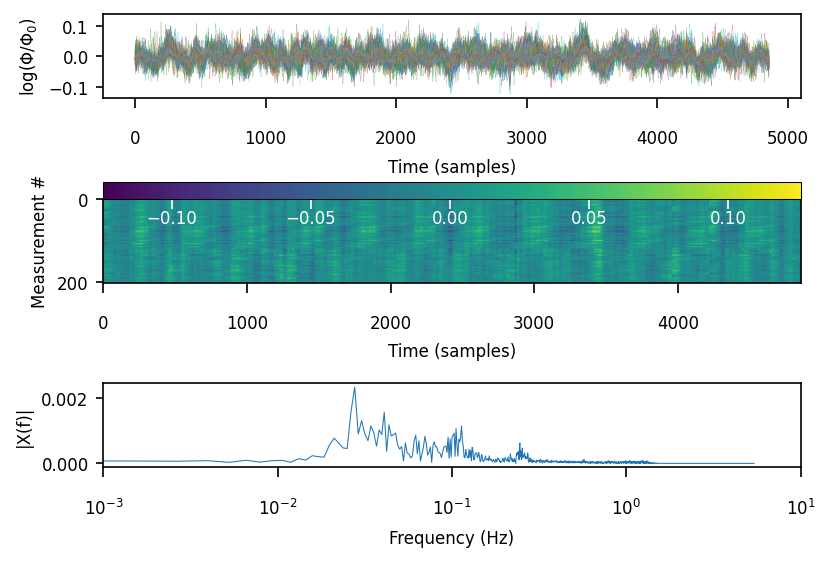

In [22]:
## Low Pass Filter 1
DynamicFilter(data,info, params,'low_pass_fft',saveImages,saveImagePath)

./Output/Output_Images/low_pass.png


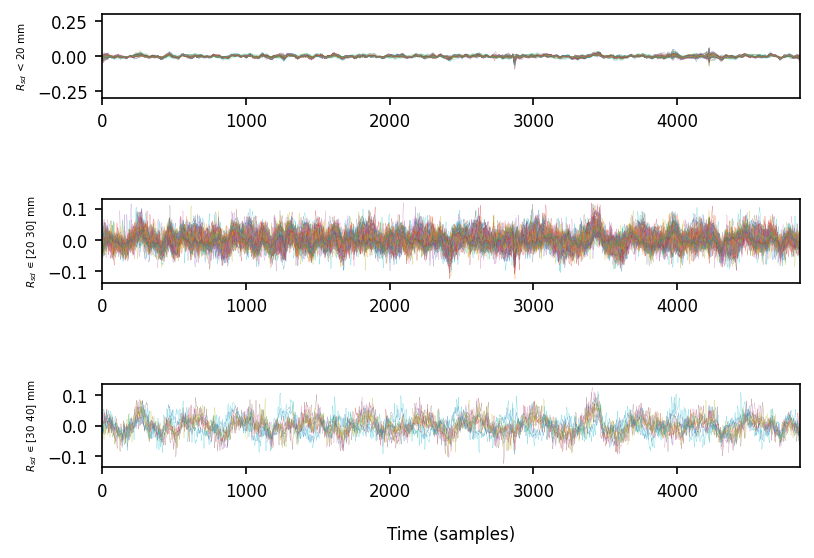

In [23]:
DynamicFilter(data,info, params,'low_pass',saveImages,saveImagePath)

./Output/Output_Images/fft_superficial_signal.png


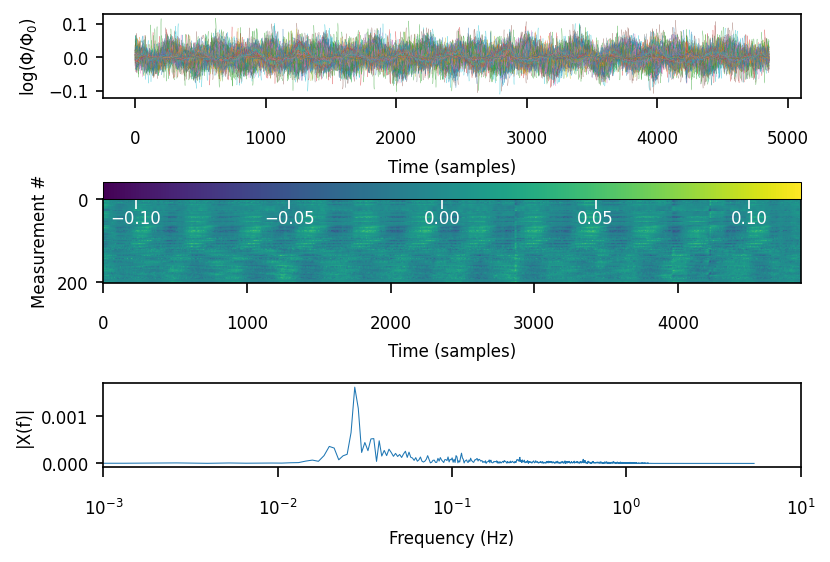

In [24]:
## Superficial Signal Regression
DynamicFilter(data,info, params,'fft_superficial_signal',saveImages,saveImagePath)

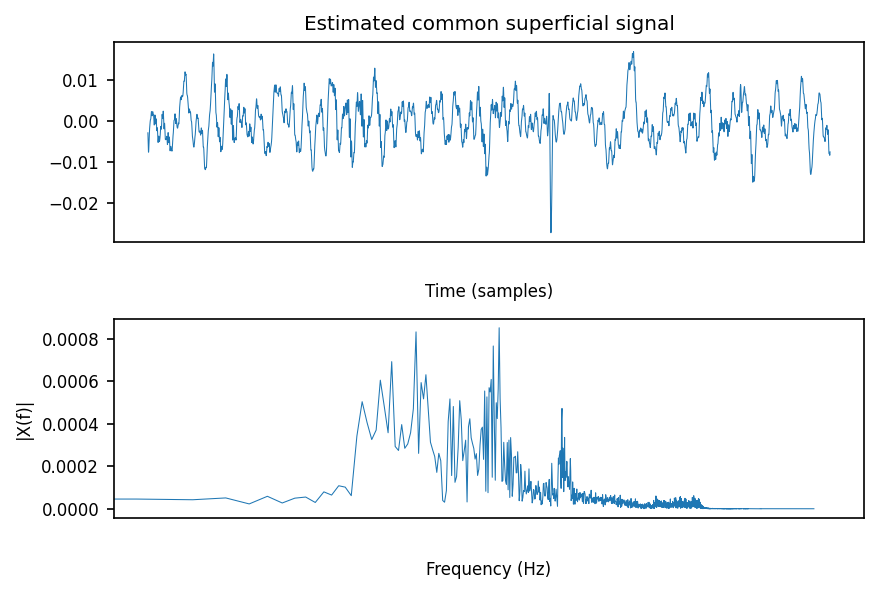

In [25]:
# Generate 2 subplots
fig = plt.figure(dpi = 150, tight_layout = True)
ddata = tx4m.detrend_tts(lmdata)
hpdata = tx4m.highpass(ddata, params['omega_hp'], info['system']['framerate'])
lp1data = tx4m.lowpass(hpdata, params['omega_lp1'], info['system']['framerate']) 
hem = tx4m.gethem(lp1data, info)
gs = gridspec.GridSpec(2,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])

ax1.plot(hem[1,:], linewidth = 0.5)
ax1.set_title('Estimated common superficial signal')
ax1.set_xlabel('Time (samples)')
arr1 = hem[1,:]
arr = np.reshape(arr1, (1,np.size(arr1)))
ftdomain,ftmag,_,_ = tx4m.fft_tts(arr,info['system']['framerate']) 
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax2.semilogx(ftdomain,ftmag, linewidth = 0.5)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('|X(f)|') # plot vs. log frequency
ax2.set_xlim([1e-3, 10])

filename = saveImagePath +'fft_SSR.png'
if saveImages == 'yes':
    plt.savefig(filename,format = 'png')

./Output/Output_Images/superficial_signal.png


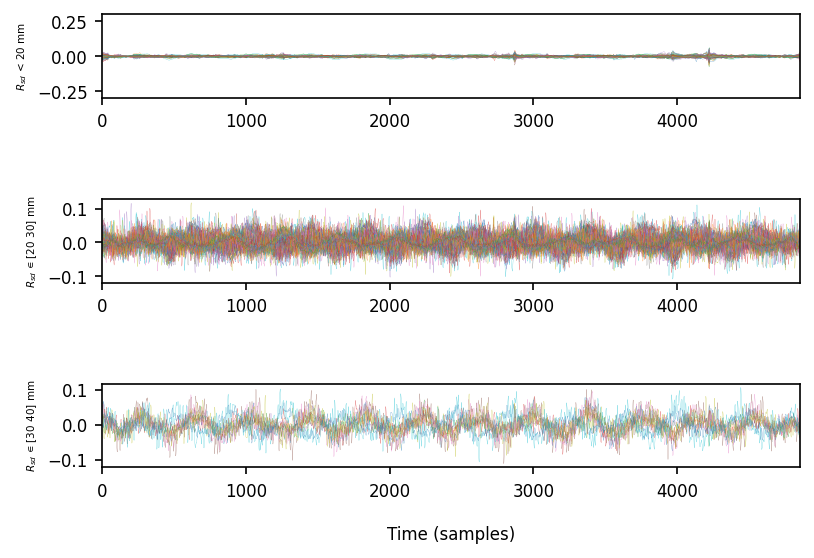

In [26]:
DynamicFilter(data,info, params,'superficial_signal',saveImages,saveImagePath)

./Output/Output_Images/fft_low_pass2.png


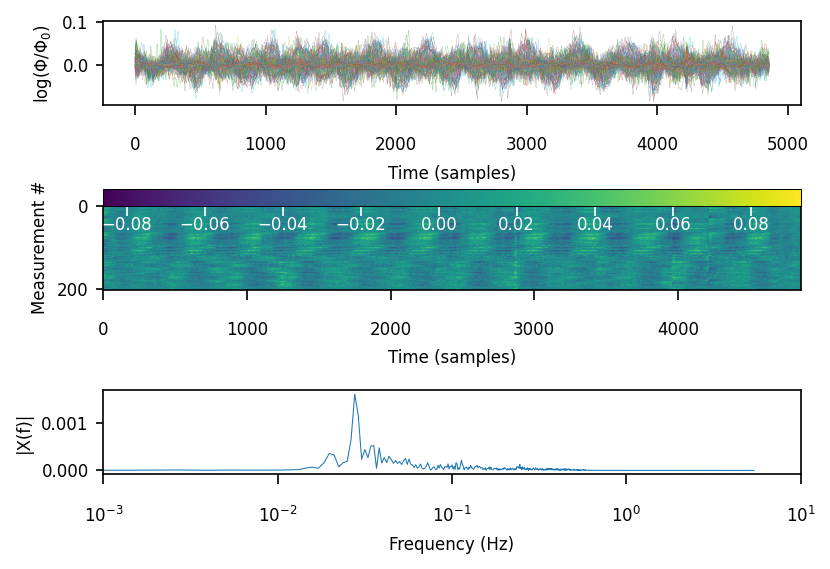

In [27]:
## Low Pass Filter 2
DynamicFilter(data,info,params,'fft_low_pass2',saveImages,saveImagePath)

./Output/Output_Images/fft_resample.png


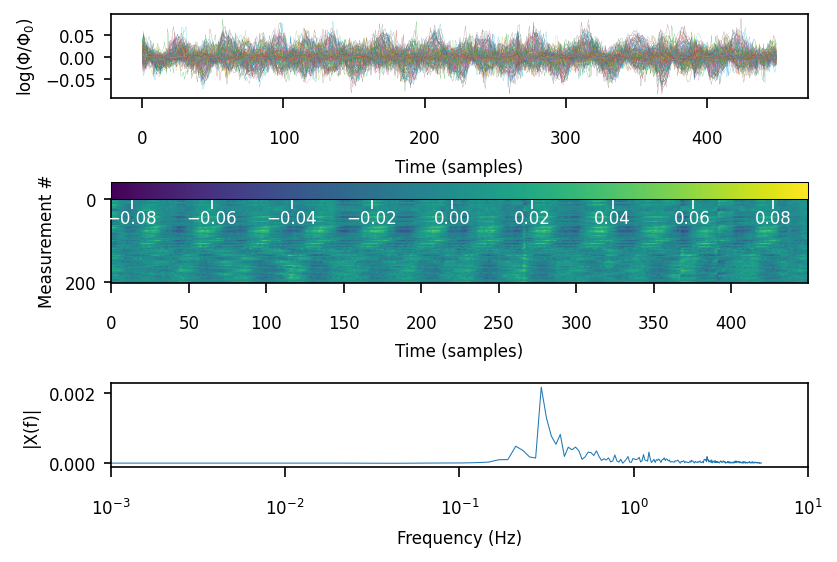

In [28]:
info_new = DynamicFilter(data,info,params, 'fft_resample',saveImages,saveImagePath)

./Output/Output_Images/resample.png


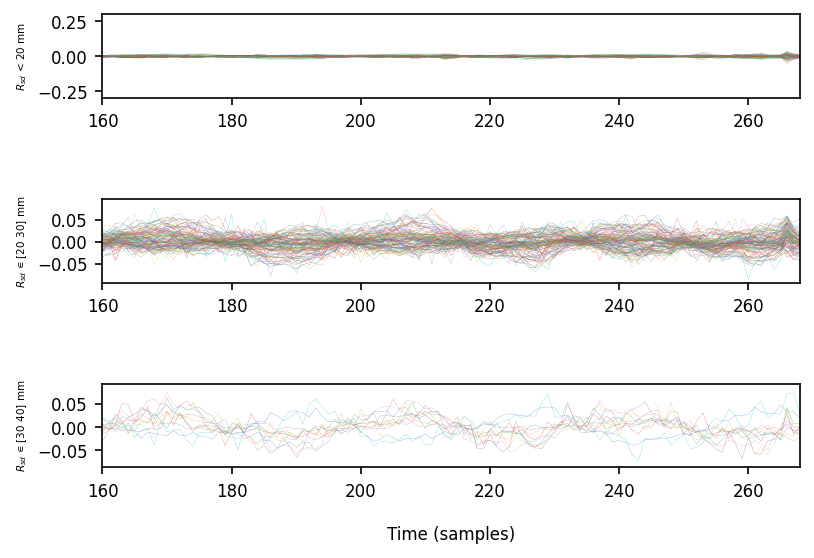

In [29]:
info_new = DynamicFilter(data,info, params,'resample',saveImages,saveImagePath)

./Output/Output_Images/fft_ba.png


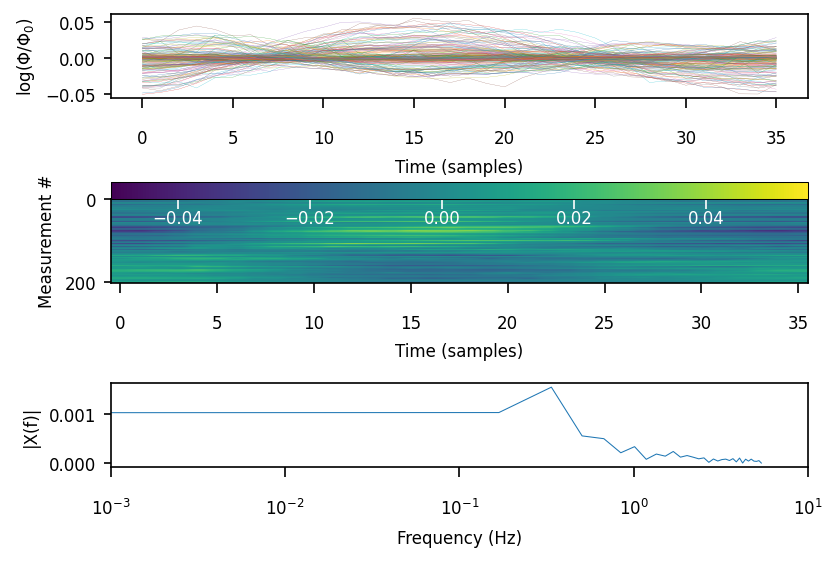

In [30]:
info_new = DynamicFilter(data,info,params, 'fft_ba',saveImages,saveImagePath)

./Output/Output_Images/ba.png


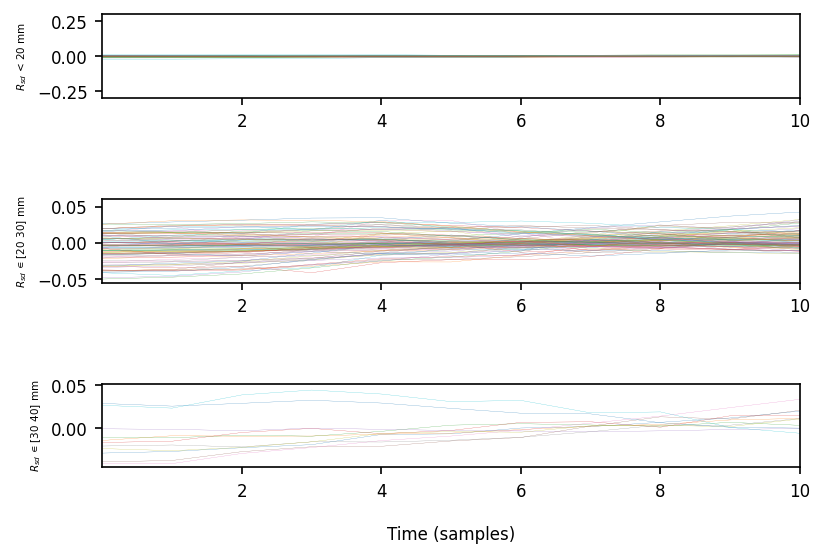

In [31]:
info_new = DynamicFilter(data,info,params, 'ba',saveImages,saveImagePath)